## We now attempt to find out if the way a SEC filing is done has an effect on the returns

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import re

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import scipy.stats as stats

# Remove warnings to keep outputs clean
import warnings
warnings.filterwarnings("ignore")

PROCESSED_DATA_FOLDER = "../../data_untracked/processed"
ABNORMAL_CSV = "snorkel_labels.csv"

## Load required datasets
1. `df_result_with_anomaly_scores_sig.csv`: Transactions with their Cumulative Abnormal Returns (CAR)
2. `FOOTNOTES.csv`: Each transactions with their individual filing comments

In [2]:
abnormal_transactions = pd.read_csv(f'{PROCESSED_DATA_FOLDER}/{ABNORMAL_CSV}')[["ACCESSION_NUMBER", "TRANS_CODE", "TRANS_ACQUIRED_DISP_CD", "snorkel_prob", "snorkel_pred"]]
abnormal_transactions = abnormal_transactions.rename(columns={"snorkel_prob" : "probability",
                                                               "snorkel_pred" : "prediction"})
print("Loading data")

Loading data


___
## Feature extraction and engineering
___

In [3]:
abnormal_transactions.head()

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,probability,prediction
0,0001181431-13-025899,S,D,0.893302,1
1,0001181431-13-025899,S,D,0.893302,1
2,0000919574-19-000485,P,A,0.478567,0
3,0000919574-19-000485,P,A,0.478567,0
4,0000919574-19-000485,P,A,0.478567,0


In [4]:
abnormal_transactions["TRANS_ACQUIRED_DISP_CD"].count()

778559

In [5]:
abnormal_transactions = abnormal_transactions.drop_duplicates(subset=["ACCESSION_NUMBER", "TRANS_ACQUIRED_DISP_CD", "TRANS_CODE", "probability"])
abnormal_transactions.shape

(303022, 5)

In [ ]:
df_features = abnormal_transactions.copy()

## Create a binary variable to extract Transcode = J
df_features["j_bin"] = np.where(df_features["TRANS_CODE"].str.upper() == "J", 1, 0)

##############################
# Sell
##############################

## Create a binary variable to extract Transcode = J and Trans Acquired = D which means J code and sell
df_features["js_bin"] = np.where((df_features["TRANS_ACQUIRED_DISP_CD"].str.upper() == "D") & (df_features["TRANS_CODE"].str.upper() == "J"), 1, 0)

## Create a binary variable to extract Transcode Not J or S but Trans Acquired = D which is sell but non S or J coded
df_features["os_bin"] = np.where((~df_features["TRANS_CODE"].str.upper().isin(["S", "J"])) & (df_features["TRANS_ACQUIRED_DISP_CD"].str.upper() == "D"), 1, 0)

## Create a binary variable to extract Transcode = S which is sell and Acquired disp cd = D (Regular Sell)
df_features["s_bin"] = np.where((df_features["TRANS_CODE"].str.upper() == "S") & (df_features["TRANS_ACQUIRED_DISP_CD"].str.upper() == "D" ), 1, 0)

##############################
# Buy
##############################

## Create a binary variable to extract Transcode = P which is Buy and Acquired disp cd = A (Regular Sell)
df_features["b_bin"] = np.where((df_features["TRANS_CODE"].str.upper() == "P") & (df_features["TRANS_ACQUIRED_DISP_CD"].str.upper() == "A"), 1, 0)

## Create a binary variable to extract Transcode = J and Trans Acquired = A which means J code and buy
df_features["jb_bin"] = np.where((df_features["TRANS_ACQUIRED_DISP_CD"].str.upper() == "A") & (df_features["TRANS_CODE"].str.upper() == "J"), 1, 0)

## Create a binary variable to extract Transcode Not J or P but Trans Acquired = A which is buy but non P or J coded
df_features["ob_bin"] = np.where((~df_features["TRANS_CODE"].str.upper().isin(["P", "J"])) & (df_features["TRANS_ACQUIRED_DISP_CD"].str.upper() == "A"), 1, 0)

##############################
# GIFTS
##############################

## Create a binary variable to extract if Transcode = G which is a gift or not
df_features["g_bin"] = np.where(df_features["TRANS_CODE"].str.upper() == "G", 1, 0)



In [8]:
print(f'rows with binary j: {sum(df_features["j_bin"])}')
print(f'rows with binary j and sell: {sum(df_features["js_bin"])} \t rows with regular sell: {sum(df_features["s_bin"])} \t rows with non-regular sell: {sum(df_features["os_bin"])}')
print(f'rows with binary j and buy: {sum(df_features["jb_bin"])} \t rows with regular buy: {sum(df_features["b_bin"])} \t\t rows with non-regular buy: {sum(df_features["ob_bin"])}')


rows with binary j: 26625
rows with binary j and sell: 6351 	 rows with regular sell: 174248 	 rows with non-regular sell: 19349
rows with binary j and buy: 20274 	 rows with regular buy: 75816 		 rows with non-regular buy: 6984


In [9]:
total_sell = sum(df_features["js_bin"]) + sum(df_features["s_bin"]) + sum(df_features["os_bin"])
total_buy = sum(df_features["jb_bin"]) + sum(df_features["b_bin"]) + sum(df_features["ob_bin"])
print(f"All cases accounted for: {len(df_features) == total_sell + total_buy}")

All cases accounted for: True


___
## Comparison
___

In [10]:
metrics = [
    "probability", "prediction"
]

In [11]:
##################################
# Define functions
##################################

def compare_complement(df, col, metrics):
    split_1 = df[df[col] == 1]
    split_2 = df[df[col] != 1]
    
    for metric in metrics:
        A = split_1[metric].dropna()
        
        # print(A)
        B = split_2[metric].dropna()
        t_stat, p_val = stats.ttest_ind(A, B, equal_var=False)
        sign = "negative" if t_stat < 0 else "positive"
        print(f"{metric}: is more {sign} when {col} is separated\n" 
              f"t-statistic = {t_stat}, p-value = {p_val}\n"
              f"mean {col} = {np.mean(A)}, mean {col} complement = {np.mean(B)}\n")
        
    print(f"{col}: n = {len(A)}, {col} complement: n = {len(B)}")

def compare_columns(df, col1, col2, metrics):
    split_1 = df[df[col1] == 1]
    split_2 = df[df[col2] == 1]
    
    for metric in metrics:
        A = split_1[metric].dropna()
        
        # print(A)
        B = split_2[metric].dropna()
        t_stat, p_val = stats.ttest_ind(A, B, equal_var=False)
        sign = "negative" if t_stat < 0 else "positive"
        print(f"{metric}: is more {sign} when {col1} compared to {col2}\n" 
              f"t-statistic = {t_stat}, p-value = {p_val}\n"
              f"mean {col1} = {np.mean(A)}, mean {col2} = {np.mean(B)}\n")
    print(f"{col1}: n = {len(A)}, {col2} : n = {len(B)}")
    

In [12]:
## The inclusion of g code not significant in the probability continous labels
compare_complement(df_features, "g_bin", metrics)

probability: is more positive when g_bin is separated
t-statistic = 0.6345651762252942, p-value = 0.5257173825310373
mean g_bin = 0.6825586404670287, mean g_bin complement = 0.6812608081126483

prediction: is more negative when g_bin is separated
t-statistic = -13.754357580665044, p-value = 6.686662022565852e-43
mean g_bin = 0.6330113758317235, mean g_bin complement = 0.6781147332935327

g_bin: n = 23295, g_bin complement: n = 279727


In [13]:
## The inclusion of j code is significant to the anomaly level at 0.05 level however, we can split it further in sells and buys
compare_complement(df_features, "j_bin", metrics)

probability: is more negative when j_bin is separated
t-statistic = -10.67447297676976, p-value = 1.4866293162409455e-26
mean j_bin = 0.6625547709204656, mean j_bin complement = 0.6831721213502635

prediction: is more negative when j_bin is separated
t-statistic = -8.341989886951733, p-value = 7.596672328888844e-17
mean j_bin = 0.6514178403755868, mean j_bin complement = 0.6768850602575281

j_bin: n = 26625, j_bin complement: n = 276397


## Compare sells

In [14]:
##################################
# Compare Regular Sell to other-coded Sell
##################################

compare_columns(df_features, "s_bin", "os_bin", metrics)

probability: is more negative when s_bin compared to os_bin
t-statistic = -5.2068012332478055, p-value = 1.9369129311362255e-07
mean s_bin = 0.6802270465914754, mean os_bin = 0.6920512866369943

prediction: is more positive when s_bin compared to os_bin
t-statistic = 5.661985030827769, p-value = 1.5136100778859424e-08
mean s_bin = 0.6670779578531748, mean os_bin = 0.6465967233448757

s_bin: n = 174248, os_bin : n = 19349


In [15]:
##################################
# Compare Regular Sell to J-coded Sell
##################################

compare_columns(df_features, "s_bin", "js_bin", metrics)

probability: is more negative when s_bin compared to js_bin
t-statistic = -13.881918903363424, p-value = 3.098617733951999e-43
mean s_bin = 0.6802270465914754, mean js_bin = 0.7314958979945633

prediction: is more negative when s_bin compared to js_bin
t-statistic = -11.27001832171322, p-value = 3.3220686525878386e-29
mean s_bin = 0.6670779578531748, mean js_bin = 0.7310659738623839

s_bin: n = 174248, js_bin : n = 6351


### J-Coded sells does not have significance compared to Other-Coded sells

In [16]:
##################################
# Compare J-coded Sell to Others-sell 
##################################

compare_columns(df_features, "js_bin", "os_bin", metrics)

probability: is more positive when js_bin compared to os_bin
t-statistic = 9.378178531904721, p-value = 8.007306169754042e-21
mean js_bin = 0.7314958979945633, mean os_bin = 0.6920512866369943

prediction: is more positive when js_bin compared to os_bin
t-statistic = 12.91565723374424, p-value = 6.711957046099309e-38
mean js_bin = 0.7310659738623839, mean os_bin = 0.6465967233448757

js_bin: n = 6351, os_bin : n = 19349


## Compare buys

In [17]:
##################################
# Compare Regular Buy to J-coded Buy
##################################

compare_columns(df_features, "b_bin", "jb_bin", metrics)

probability: is more positive when b_bin compared to jb_bin
t-statistic = 20.472636322115783, p-value = 1.7408226567797087e-92
mean b_bin = 0.6884447822361061, mean jb_bin = 0.6409583864848536

prediction: is more positive when b_bin compared to jb_bin
t-statistic = 22.528764098504464, p-value = 1.771372836412773e-111
mean b_bin = 0.7115120818824523, mean jb_bin = 0.6264673966656802

b_bin: n = 75816, jb_bin : n = 20274


In [18]:
##################################
# Compare Regular Buy to other-coded Buy
##################################

compare_columns(df_features, "b_bin", "ob_bin", metrics)

probability: is more positive when b_bin compared to ob_bin
t-statistic = 3.6357640172606147, p-value = 0.0002789130180022402
mean b_bin = 0.6884447822361061, mean ob_bin = 0.6748127799578376

prediction: is more positive when b_bin compared to ob_bin
t-statistic = 13.635344031299386, p-value = 7.088388273305611e-42
mean b_bin = 0.7115120818824523, mean ob_bin = 0.629581901489118

b_bin: n = 75816, ob_bin : n = 6984


In [19]:
##################################
# Compare J-coded Buy to other-coded Buy
##################################

compare_columns(df_features, "jb_bin", "ob_bin", metrics)

probability: is more negative when jb_bin compared to ob_bin
t-statistic = -8.048502829825074, p-value = 9.16270990666235e-16
mean jb_bin = 0.6409583864848536, mean ob_bin = 0.6748127799578376

prediction: is more negative when jb_bin compared to ob_bin
t-statistic = -0.46459614862806436, p-value = 0.642229019607282
mean jb_bin = 0.6264673966656802, mean ob_bin = 0.629581901489118

jb_bin: n = 20274, ob_bin : n = 6984


### Sell
Propose to split sell into 3 Features: Regular sell, J-coded sells and Other sells

### Buy
Propose to split sell into 3 Features: Regular Buys, J-coded buy and other buys

However, we will remove one of the column to remove collinearity. Then we will check the significance of the model

___
## Checking significance in model
___

In [20]:
df_features.head()

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,probability,prediction,j_bin,js_bin,os_bin,s_bin,b_bin,jb_bin,ob_bin,g_bin
0,0001181431-13-025899,S,D,0.893302,1,0,0,0,1,0,0,0,0
2,0000919574-19-000485,P,A,0.478567,0,0,0,0,0,1,0,0,0
5,0000891092-07-001488,J,D,1.000000,1,1,1,0,0,0,0,0,0
6,0000891092-07-001456,S,D,1.000000,1,0,0,0,1,0,0,0,0
18,0000891092-10-001405,S,D,1.000000,1,0,0,0,1,0,0,0,0


In [21]:
def find_significance(data, columns, label):
    data = data.dropna(subset=[label])
    X = data[columns]
    y = data[label]
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=123)
    
    X_with_const = sm.add_constant(train_x)
    model = sm.Logit(train_y, X_with_const).fit()
    # results = model.fit()

    print(model.summary())

In [22]:
variables = ['js_bin', 'os_bin','b_bin', 'jb_bin', 'ob_bin'] # Removed "s_bin" to ensure that collinearity is removed
label = ["probability"]
find_significance(df_features, variables, label[0])

Optimization terminated successfully.
         Current function value: 0.589202
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            probability   No. Observations:               242417
Model:                          Logit   Df Residuals:                   242411
Method:                           MLE   Df Model:                            5
Date:                Sat, 29 Mar 2025   Pseudo R-squ.:                -0.07884
Time:                        13:37:15   Log-Likelihood:            -1.4283e+05
converged:                       True   LL-Null:                   -1.3239e+05
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7543      0.006    131.310      0.000       0.743       0.766
js_bin         0.2515      0.

Removed ob_bin because the variable is not significant at 0.05 significance level

In [23]:
variables = ['js_bin', 'b_bin', 'jb_bin', "os_bin"] 
label = ["probability"]
find_significance(df_features, variables, label[0])

Optimization terminated successfully.
         Current function value: 0.589202
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            probability   No. Observations:               242417
Model:                          Logit   Df Residuals:                   242412
Method:                           MLE   Df Model:                            4
Date:                Sat, 29 Mar 2025   Pseudo R-squ.:                -0.07884
Time:                        13:37:16   Log-Likelihood:            -1.4283e+05
converged:                       True   LL-Null:                   -1.3239e+05
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7532      0.006    133.736      0.000       0.742       0.764
js_bin         0.2526      0.

### The variables:

js_bin: Indicates 1 if it is a J-coded sell 0 otherwise

b_bin: Indicates 1 if it is a P-coded buy and trans acquired A 0 otherwise

jb_bin: Indicates 1 if it is a J-coded buy 0 otherwise

os_bin: Indicates 1 if it is a non-J non-S coded sell 0 otherwise

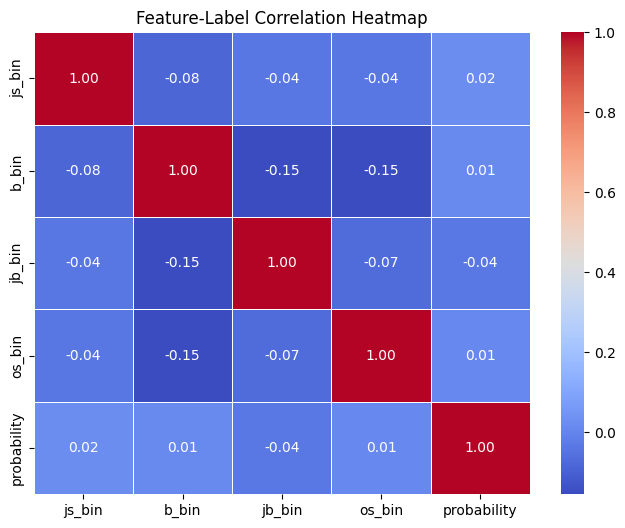

In [24]:
corr = df_features[variables + label].corr(method="pearson")
# corr = df_features.corr(method="pearson")
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature-Label Correlation Heatmap")
plt.show()